# Time Space diagram

## Data
- queue length data from Arane's data portal
- Public Transport data

Time period: Based on previous analysis, 1 hour at a specific day is chosen \\
→ 8th of April, 

In [1]:
#packages
import pandas as pd
import numpy as np
import math
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn
from datetime import datetime, timedelta
from dateutil import parser
from scipy.spatial import distance

#google drive connection
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Variables specific to the analysis

In [2]:
#Time
#-----------------------
####ENTER HERE YOUR DESIRED TIME PERIOD####
date_start = '08-04-2022'
date_end = '09-04-2022'
###########################################

#unixtimestamp milliseconds
start_ts = int(1000*datetime.strptime(date_start, '%d-%m-%Y').timestamp())
end_ts = int(1000*datetime.strptime(date_end, '%d-%m-%Y').timestamp())

#timestep for aggregation
dt = 1/6          #every 10 s 10s/60s
#car specific variables
#-----------------------
vris = [90, 89, 111]
vris_txt = ['090', '089' ,'111'] 
directions = ['N', 'O', 'Z', 'W']

#PT specific variables
#----------------------
buslines = ['u001', 'u010', 'u034', 'u047']
#convention for bus stops: 
    #first key: vri
    #second key: busline
    #4 busstops order before and after the intersection, in both travel directions
busstops = {89: {'u001':['50002380', '50001270', '50001282', '50002370'], 
                        'u010':['50001300', '50001270', '50001282','50001290'],
                        'u034':['50001300', '50001270', '50001282','50001290'],
                        'u047':['50001300','50001400', '50001390', '50001290']},
                    90: {'u001':[], 
                        'u010':['50006470', '50001300', '50001290', '50006480'],
                        'u034':[],
                        'u047':[]},
                   111: {'u001':['50002360', '50001270', '50001282', '50002350'], 
                        'u010':['50001300', '50001232', '50001241','50001290'], 
                        'u034':['50001300', '50001232', '50001241','50001290'],
                        'u047':[]}}
for vri in vris: 
  for line in buslines:
    busstops[vri][line] = [int(x) for x in busstops[vri][line]]
#at netwrk level etnry and exit busstops for time-space diagram per line, and direction
entry_busstops = {'u001': {'OW': 50002380,'WO': 50001282}, 'u010': {'OW': 50006470,'WO': 50001241}, 'u034': {'OW': 50100420,'WO': 50001241}, 'u047': {'OW': 51180036,'WO':50001390 }}
exit_busstops = {'u001': {'OW': 50001270,'WO': 50002370}, 'u010': {'OW': 50001232,'WO': 50006480}, 'u034': {'OW': 50001232,'WO': 50100410}, 'u047':{'OW':50001400 ,'WO': 51180030}}

#coordinates for entry and exit points of the analysed area:
coord_O = [137030, 453032]
coord_W = [135892, 453201]
coord_S = [136647, 453079]
coord_N = [136675, 453186]

coords_inout = {'u001': {'OW':[coord_S, coord_W], 'WO': [coord_W, coord_S]}, 'u010': {'OW': [coord_O, coord_W], 'WO': [coord_W, coord_O]}, 
                'u034': {'OW': [coord_O, coord_W], 'WO': [coord_W, coord_O]}, 'u047': {'OW': [coord_O, coord_N], 'WO': [coord_N, coord_O]}}

#for intersection 111: bus lines 10 and 34 are considered over the whole Socrateslaan intersection 
#(the bus stop on the intersection is not considered, because in the middle of the intersection)

## Data import
- Queue length data
- PT data
- (status of the INM system)

In [ ]:
#queuelength from AFM dataportal 
interval = end_ts-start_ts
twohours = 2*60*60*1000
if interval > twohours:
    start_prov = start_ts
    q_estimator= pd.DataFrame()
    #data_agg =pd.DataFrame(data_agg)
    for i in range(round(interval/twohours)):
        start_prov = start_ts + i*twohours
        end_prov = start_prov + twohours
        #print('{} start time: {} \n end time: {}'.format(i, timefromtimestamp(start_prov), timefromtimestamp(end_prov)))
        #load data
        with urlopen("https://utrechtdvmproductie.mobimaestro.nl/afmdataportal/data/wachtrijschatter?startTime={}&endTime={}".format(start_prov, end_prov)) as f:
            data = json.loads(f.read())
        #normalize data
        data_norm = pd.json_normalize(data['result'], meta = ['timestamp', 'timestamp_actueel' ], record_path=['opstelvakken'])
        df = pd.DataFrame(data_norm)
        #add new data to aggregated df
        q_estimator = pd.concat([q_estimator, df])


#time formatting
#function to get formated time from unix timestamp (AFM data)
def timefromtimestamp(timestamp):
    time_h = pd.to_datetime(datetime.fromtimestamp(timestamp/1000))
    return time_h

q_estimator['time'] = [timefromtimestamp(x) for x in q_estimator['timestamp']]


#resample data of queue estimator
queuelength = {v:{d:{} for d in directions}for v in vris}
for idx,vri in enumerate(vris):
    vri_txt = vris_txt[idx]
    #df of intersection
    df_vri = q_estimator[q_estimator.opstelvak_id.str.contains('UTR_{}_'.format(vri_txt))].reset_index(drop = True)

    for d in directions:
        #df of direction at intersection vri
        df_d = df_vri[df_vri.opstelvak_id.str.contains('UTR_{}_{}'.format(vri_txt, d))]
        #set time as index
        df_d.set_index('time', inplace =True)
        #time aggregation on time interval dt
        df_d= df_d.resample('{}T'.format(dt)).agg({'buffervulling_m': 'mean', 'opstelvak_id': 'first'})
        queuelength[vri][d] = df_d

In [3]:
#PT
#==
#initialisation
bus_agg_compl = {v:{l: {d: pd.DataFrame() for d in range(2)} for l in buslines} for v in vris}
#import
date_ts = datetime.fromtimestamp(start_ts/1000)
while not date_ts == datetime.fromtimestamp(end_ts/1000):
    date_string = date_ts.strftime("%Y%m%d")
    with open("/content/gdrive/MyDrive/Colab Notebooks/PDM/NDOV/kv6/kv6-{}.log.csv".format(date_string)) as file:
        kv6 = pd.read_csv(file, sep= ",", index_col=0)
    
    #update date_timestep
    date_ts += timedelta(days=1)
    if date_ts == datetime.fromtimestamp(end_ts/1000):
        break
    

In [4]:
kv6.head()

,receive,message,vehicle,messagetype,operatingday,dataownercode,lineplanningnumber,journeynumber,reinforcementnumber,userstopcode,passagesequencenumber,distancesincelastuserstop,punctuality,rd_x,rd_y,blockade,vehiclenumber,wheelchairaccessible,source,numberofcoaches
0,2022-04-08T05:41:22.305975,2022-04-08T05:41:21.597+02:00,2022-04-08T05:41:21.000+02:00,DELAY,2022-04-08,QBUZZ,u001,2001,0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,SERVER,NaN
1,2022-04-08T05:41:23.621540,2022-04-08T05:41:22.598+02:00,2022-04-08T05:41:21.000+02:00,INIT,2022-04-08,QBUZZ,u001,2001,0,59151801.0,0.0,NaN,NaN,NaN,NaN,600111.0,4006.0,False,VEHICLE,1.0
2,2022-04-08T05:41:49.518536,2022-04-08T05:41:49.122+02:00,2022-04-08T05:41:47.000+02:00,ONSTOP,2022-04-08,QBUZZ,u001,2001,0,59151801.0,0.0,NaN,-552.0,134429.0,459524.0,NaN,4006.0,NaN,VEHICLE,NaN
3,2022-04-08T05:42:18.496156,2022-04-08T05:42:17.390+02:00,2022-04-08T05:42:15.000+02:00,ONSTOP,2022-04-08,QBUZZ,u001,2001,0,59151801.0,0.0,NaN,-524.0,134429.0,459525.0,NaN,4006.0,NaN,VEHICLE,NaN
4,2022-04-08T05:42:45.392153,2022-04-08T05:42:45.078+02:00,2022-04-08T05:42:44.000+02:00,ONSTOP,2022-04-08,QBUZZ,u001,2001,0,59151801.0,0.0,NaN,-495.0,134433.0,459528.0,NaN,4006.0,NaN,VEHICLE,NaN


## Preprocessing

In [ ]:
#Calculation of distance based on coordinates
#initialisation
bus_traj = {l: pd.DataFrame() for l in buslines}
bus_start = {'u001': {'OW': 50008050, 'WO': 59151801}, 'u010': {'OW': 50006542, 'WO': 51112300}, 'u034': {'OW': 50201100, 'WO': 50000141}, 'u047': {'OW': 50001400, 'WO': 50000122}}
bus_dir = ['OW', 'WO']
#df per line
for line in buslines:
  df_bus = kv6[kv6.lineplanningnumber == line].reset_index(drop= True)
  trips = df_bus.journeynumber.unique()
  for trip in trips:
    #df per trip / journeynumber
    df_trip = df_bus[df_bus.journeynumber == trip].reset_index(drop= True)   
### direction OW/WO of the bus   
#identify the direction of the bus based on the initial bus stop 
    first_stp = df_trip[df_trip.userstopcode >0].reset_index(drop = True).userstopcode[0]
    if first_stp == bus_start[line]['OW']:
      df_trip['direction'] = 'OW'
    elif first_stp == bus_start[line]['WO']:
      df_trip['direction'] = 'WO'
    else:
      df_trip['direction'] = 'unknown'
    #display(df_trip)

    #initialisation df
    df_trip_agg=pd.DataFrame()
    for idd,direction in enumerate(bus_dir):
      df_trip_d = df_trip[df_trip.direction == direction].reset_index(drop = True)
      #time formatting
      df_trip_d['time'] = [parser.parse(x) for x in df_trip.receive]
      #calculate euclidean distance
      df_trip_d.insert(13, "delta_d",0, True)
      #cumulated distance
      df_trip_d.insert(14, "cum_dist",0, True)
      #elapsed time between two data points
      df_trip_d.insert(17, "delta_t",0, True)
      #distance to entry point
      entrypoint= coords_inout[line][direction][0]
      df_trip_d.insert(15, "dist_entry",1000, True)
      #distance to exit point
      exitpoint= coords_inout[line][direction][1]
      df_trip_d.insert(16, "dist_exit",1000, True)
      for i in range(len(df_trip_d)-1):
        point1 = np.array((df_trip_d.rd_x[i], df_trip_d.rd_y[i]))
        point2 = np.array((df_trip_d.rd_x[i+1], df_trip_d.rd_y[i+1]))
        if point1.any() == np.nan: 
          df_trip_d['delta_d'][i]= 0
        elif point2.any() == np.nan:
          df_trip_d['delta_d'][i+1]= 0
        elif not np.isnan(point1 * point2).any():
          df_trip_d['delta_d'][i+1]= distance.euclidean(point1,point2)
          #cumulated distance
          df_trip_d['cum_dist'][i+1] = df_trip_d['cum_dist'][i] + df_trip_d['delta_d'][i+1]
          #distance to entry point
          df_trip_d['dist_entry'][i+1]= distance.euclidean(entrypoint,point2)
          #distance to exit point
          df_trip_d['dist_exit'][i+1]= distance.euclidean(exitpoint,point2)
          #elapsed time between two datapoints
          df_trip_d['delta_t'][i+1] = (df_trip_d['time'][i+1] - df_trip_d['time'][i]).total_seconds()

      #set time as index
      df_trip_d.set_index('time', inplace = True)
      #Supersampling: time aggregation to 10s (to match queue length data, since in the same plot)
      df_trip_agg_d = df_trip_d.resample('{}T'.format(dt)).agg({'messagetype': 'first', 'punctuality':'mean', 'direction': 'first', 'delta_t': 'sum', 'delta_d': 'sum',
                                                              'cum_dist': 'mean', 'delta_t': 'mean', 'dist_entry': 'mean', 'dist_exit': 'mean', 'rd_x':'mean', 'rd_y':'mean',
                                                              'journeynumber': 'first', 'userstopcode': 'first'})
      #add data frames together level of all trips per direction
      df_trip_agg = pd.concat([df_trip_agg, df_trip_agg_d])
    #add dataframes toegether both directions per line  
    bus_traj[line] = pd.concat([bus_traj[line], df_trip_agg])    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to b

### Chosen 1st Method to select data which is actually on 't Goylaan
- first calculate the euclidean distance between two consectuive data points, 
- then calculate the cumulative distance from the start per trip
- for each data point calculate the euclidean distance from the entry and exit point of the area of interest
- per trip: find the minimum, and suppose that point as the starting/end point on 't Goylaan of that trips's trajectory.
- per trip: define the direction of the bus (OW or WO)
- per trip: distance on 't Goylaan = cum_dist - cumulative dist of the entry point

Hypothesis: the bus has always the same trajectory and the calculation of the distance between the data points yield roughly the same values for different trips of the same busline, such that we can assume that the total length of all trips from the same line have the same length.

In [ ]:
##most accurate plot

#select part of trajectory which is on 't Goylaan
#identification by an entry and exit point in the middle of the street, and where the distance to these points is minimum gives the entry and exit rows of the dataframe, 
#the rows in between are in the analysed network area
bus_traj_goy = {l: pd.DataFrame() for l in buslines}
for line in buslines: 
  trips = bus_traj[line]['journeynumber'].unique()
  for trip in trips:
    df_trip = bus_traj[line][bus_traj[line]['journeynumber'] == trip].reset_index(drop = False)
    if not df_trip.empty:
      minO = df_trip.dist_entry.min()
      minW = df_trip.dist_exit.min()
      indexO = int(df_trip.index[df_trip.dist_entry == minO][0])
      indexW = int(df_trip.index[df_trip.dist_exit== minW][0])
      if indexO > indexW:
        direction = 'WO' #direction of the bus on the network
        df_trip_goylaan = df_trip[indexW :indexO+1].reset_index(drop = True)
        df_trip_goylaan['dist_goy'] = [x- df_trip_goylaan.cum_dist[0] for x in df_trip_goylaan.cum_dist]
        df_trip_goylaan['dir'] = direction

      elif indexW > indexO:
        direction = 'OW'
        df_trip_goylaan = df_trip[indexO :indexW+1].reset_index(drop = True)
        df_trip_goylaan['dist_goy'] = [x- df_trip_goylaan.cum_dist[0] for x in df_trip_goylaan.cum_dist]
        df_trip_goylaan['dir'] = direction
      
      #add data frames together
      bus_traj_goy[line] = pd.concat([bus_traj_goy[line], df_trip_goylaan]).reset_index(drop= True) 

  bus_traj_goy[line].set_index('time', inplace = True)


## Plot

- time-space diagram of PT over the area of analysis
- add queuelength at the intersection of the same direction as bus, or of competing movements; use y-offset to adjust the vertical 0 for the queuelength




In [ ]:
#parameters for all plots
#------------------------
#time period
h_start = 15
h_end = 16

# distance of intersections and busstops to starting point 0
d_intersections = {'OW': [134, 380, 690], 'WO': [340, 730, 1006]}
d_busstops = {'OW': [268,763], 'WO': [410, 910]}

#colormap for trips and buses
color_bus = {'u010': 'limegreen', 'u034':  'orange'}

#legend
import matplotlib.patches as mpatches 
import matplotlib.lines as mlines

legend10 = mpatches.Patch(color='limegreen', label='Busline 10') 
legend34 = mpatches.Patch(color='orange', label='Busline 34')
legendql = mpatches.Patch(color='blue', label='Queue length')
legendstp = mlines.Line2D([], [], linestyle = '--', color='black', marker='x',
                          markersize=7, label='at busstop')

#annotation of vris and busstops
annotations_busstop = {'OW': ['Busstop Goylaan', 'Busstop Socrateslaan'], 
               'WO': ['Busstop Socrateslaan', 'Busstop Goylaan']}
annotations_intersections = {'OW': ['VRI 90',  'VRI 89', 'VRI 111'], 
               'WO': ['VRI 111',  'VRI 89', 'VRI 89']}

### Trajectory on 't Goylaan


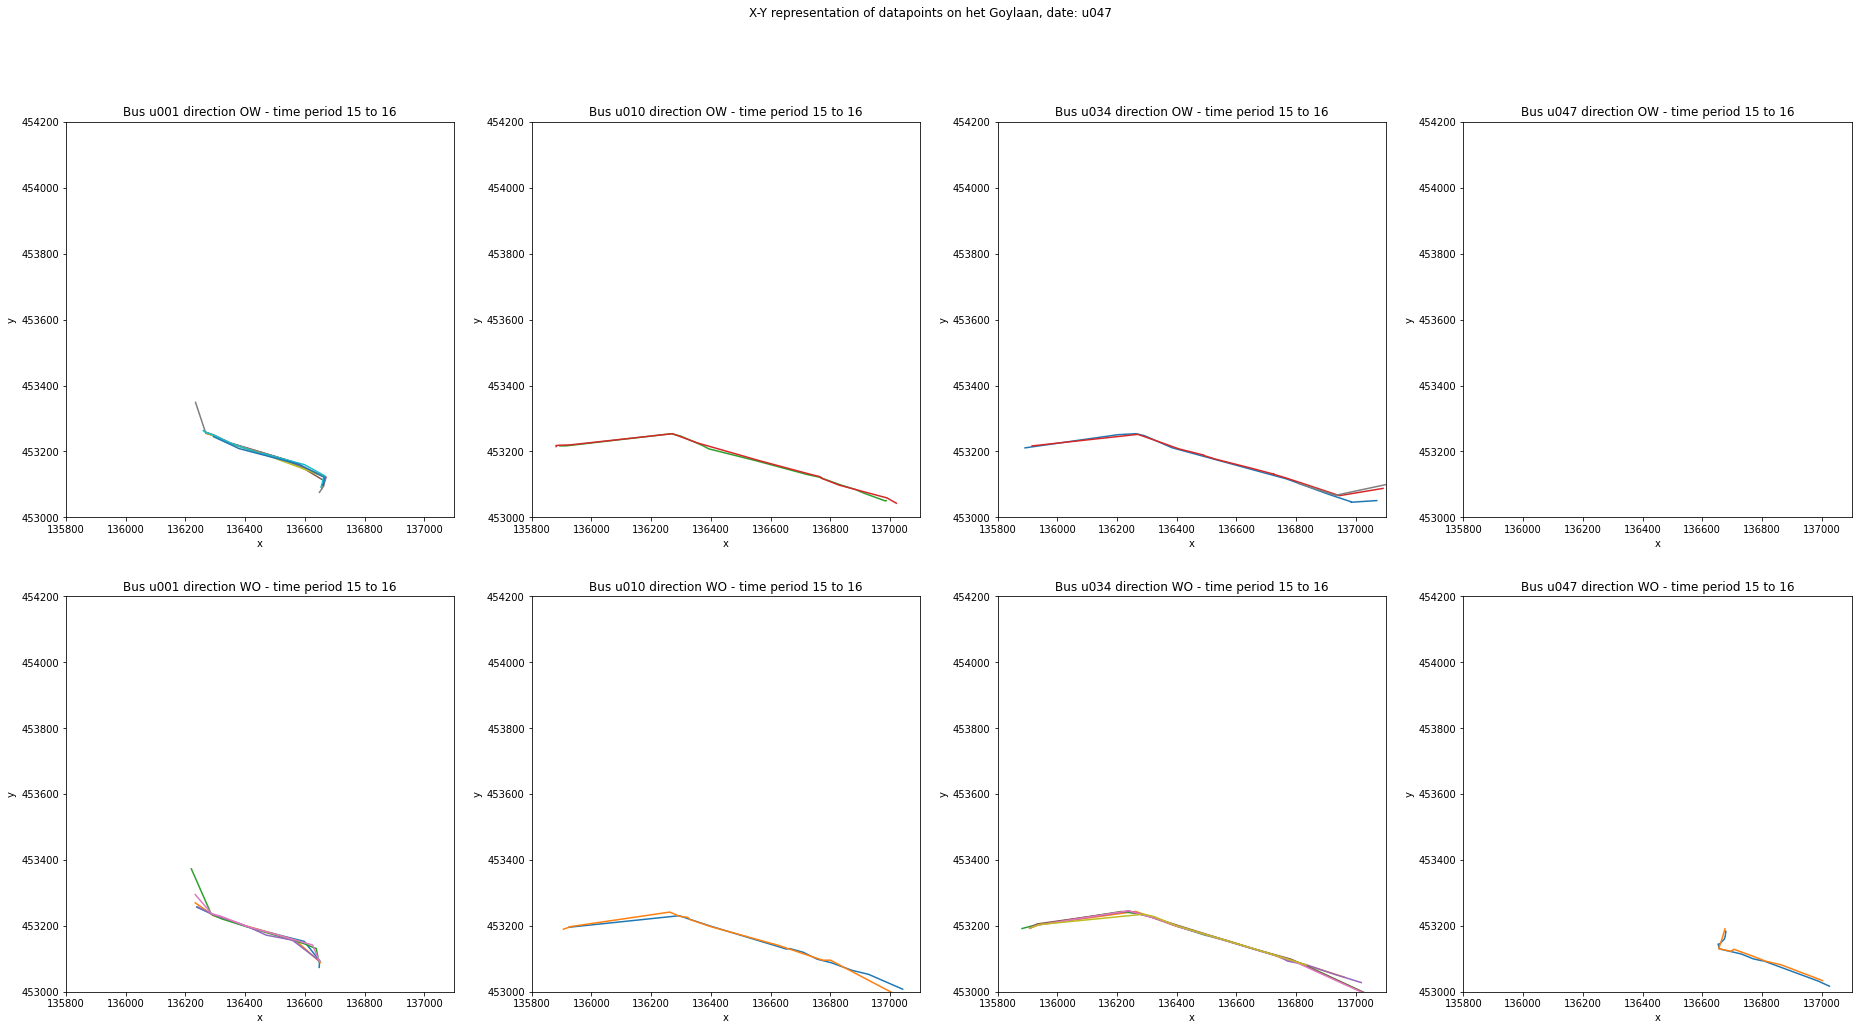

In [ ]:
#plot x-y coordinates of the goylaan part of trips 
#plot time-space diagram
fig = plt.figure(figsize=(len(buslines)*8, 2*8))
plt.suptitle('X-Y representation of datapoints on het Goylaan, date: {}'.format(line, date_start))
fnum = 0
for direction in ['OW', 'WO']:
  for line in buslines: 
    #figure settings
    fnum = fnum+ 1
    ax=plt.subplot(2,4, fnum)
    ax.grid(visible = None, which = 'both')
    ax.set_xlabel('x')
    ax.set_xlim(135800, 137100)
    ax.set_ylabel('y')
    ax.set_ylim(453000, 454200) #use this for squared coordinates and have closest road presentation (but overall image is smaller)
    ax.set_title('Bus {} direction {} - time period {} to {}'.format(line, direction, h_start, h_end))
    

    #only take time which is in the desired hour
    df_line = bus_traj_goy[line][bus_traj_goy[line].index.hour>= h_start]
    df_line = df_line[df_line.index.hour < h_end]
    df_line=df_line.dropna()

    for trip in df_line.journeynumber.unique():
      df_trip = df_line[df_line.journeynumber == trip]
      df_trip = df_trip[df_trip.direction == direction]

      x = df_trip.rd_x
      y = df_trip.rd_y
      ax.plot(x, y, label = 'trip {}'.format(trip))
      #ax.legend(loc='upper right')
      #plt.show()
  #save figure
  #fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/Time Space diagram/xy_representation_dir_{}_time_{}_to_{}.pdf'.format(direction, h_start, h_end))


The plot of x and y coordinate for the segments which are selected for being on het Goylaan show in a qualitative way how accurate the method oh choosing hte segments is. The buses 10 and 34 which are actually passing through the entry and exit points are the most accurate and should be used for the further analysis. Whereas the buses which are turning (1 and 47) show more deviation. In fact, the data points are given at irregrular locations, and that's why to choose the closest data point to the entry/exit-point can have quite high variations. 



### Time-space diagram

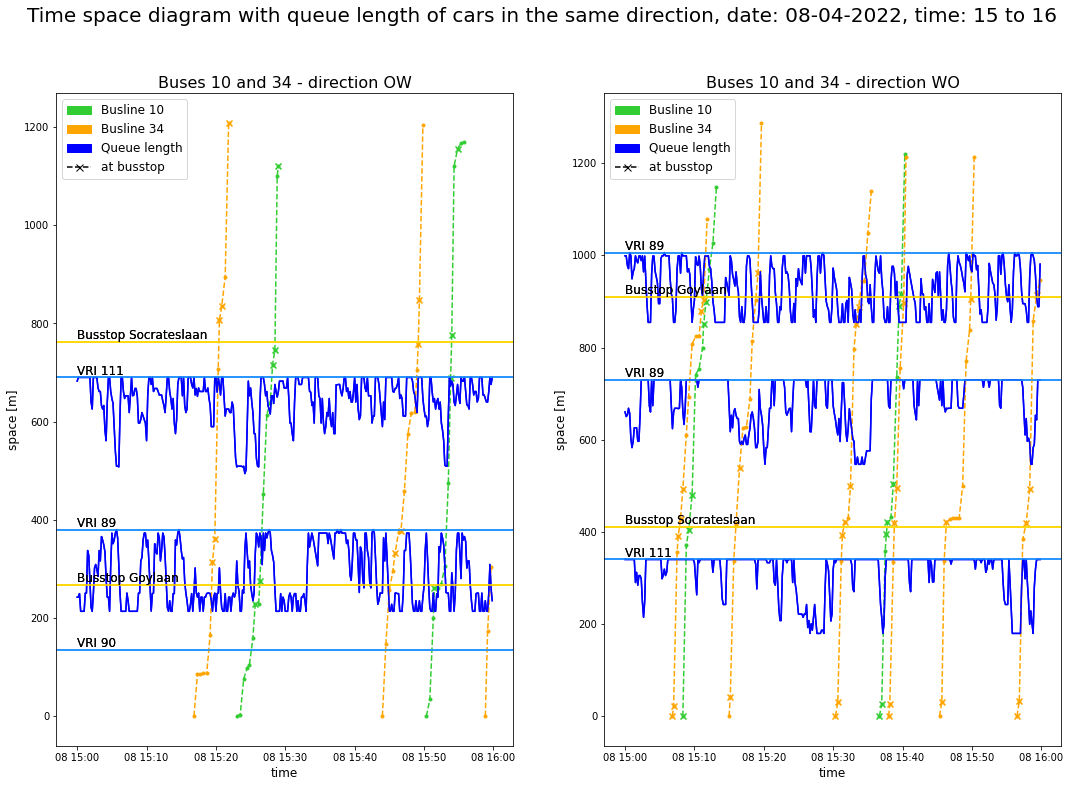

In [ ]:
#plot time-space diagram
fig = plt.figure(figsize=(18, 12))
plt.suptitle('Time space diagram with queue length of cars in the same direction, date: {}, time: {} to {}'.format(date_start, h_start, h_end), fontsize = 20)
fnum = 0
for direction in ['OW', 'WO']:
  #figure settings
  fnum = fnum+ 1
  ax=plt.subplot(1,2, fnum)
  ax.grid(visible = None, which = 'both')
  ax.set_xlabel('time', fontsize= 12)
  ax.set_ylabel('space [m]', fontsize= 12)
  ax.set_title('Buses 10 and 34 - direction {}'.format(direction), fontsize = 16)
  for line in ['u010', 'u034']: 
    
    
    ## bus trajcetory
    #only take time which is in the desired hour
    df_line = bus_traj_goy[line][bus_traj_goy[line].index.hour>= h_start]
    df_line = df_line[df_line.index.hour < h_end]
    df_line=df_line.dropna()
    trips = df_line.journeynumber.unique()

    for idt, trip in enumerate(trips):
      df_trip = df_line[df_line.journeynumber == trip]
      df_trip = df_trip[df_trip.direction == direction]
      t = df_trip.index
      dist = df_trip.dist_goy.values
      markerlabels = df_trip.messagetype
      ax.plot(t, dist, color = color_bus[line] , marker = '.', linestyle= '--', label = 'trip {}'.format(trip))
      for idx, markerlabel in enumerate(markerlabels):
        if markerlabel == 'DEPARTURE' or markerlabel == 'ARRIVAL':
          ax.scatter(t[idx], dist[idx], linewidths = 5, marker = 'x', color = color_bus[line])
          #ax.annotate( markerlabel, (t[idx],dist[idx]), xytext=(3,3), textcoords='offset pixels')
        else :
          pass
      #if line == 'u010' and direction == 'WO':
        #display(df_trip)
        #pass

    ## queue length 
    for idx, d_int in enumerate(d_intersections[direction]):
      #define approach of the intersection where queuelength should be plotted from
      if direction == 'OW':
        d= 'O'
        vri = vris[idx]
      elif direction == 'WO':
        d= 'W'
        vri = vris[2-idx]
      df_ql = queuelength[vri][d][queuelength[vri][d].index.hour >= h_start]
      df_ql = df_ql[df_ql.index.hour < h_end]
      t = df_ql.index
      if vri == 111: 
        offset_ql = queuelength[vri][d].buffervulling_m.min()
        ql = -(df_ql.buffervulling_m-offset_ql) + d_int # offset of d_intersection to plot ql at the height of the intersection
      else:
        ql = -df_ql.buffervulling_m + d_int # offset of d_intersection to plot ql at the height of the intersection
      ax.plot(t, ql, color = 'blue')
    
    #plot horizons of busstops and intersetions
    for i,value in enumerate(d_busstops[direction]):
      plt.axhline(y=value, color='gold', linestyle='-')
      ax.text(t[0], value, annotations_busstop[direction][i], horizontalalignment='left', verticalalignment= 'bottom', multialignment='center', fontsize = 12)
    for i,value in enumerate(d_intersections[direction]):
      plt.axhline(y=value, color='dodgerblue', linestyle='-')
      ax.text(t[0], value, annotations_intersections[direction][i], horizontalalignment='left', verticalalignment= 'bottom', multialignment='center', fontsize = 12)
    
      #plt.show()
  
  plt.legend(handles= [legend10, legend34, legendql, legendstp], loc = 'upper left', fontsize= 12)
#save figure
fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/Time Space diagram/timespace_time_{}_to_{}.png'.format(h_start, h_end))


In [ ]:
#plot delay of the buses


### Time-space diagram of buses with competing car movements

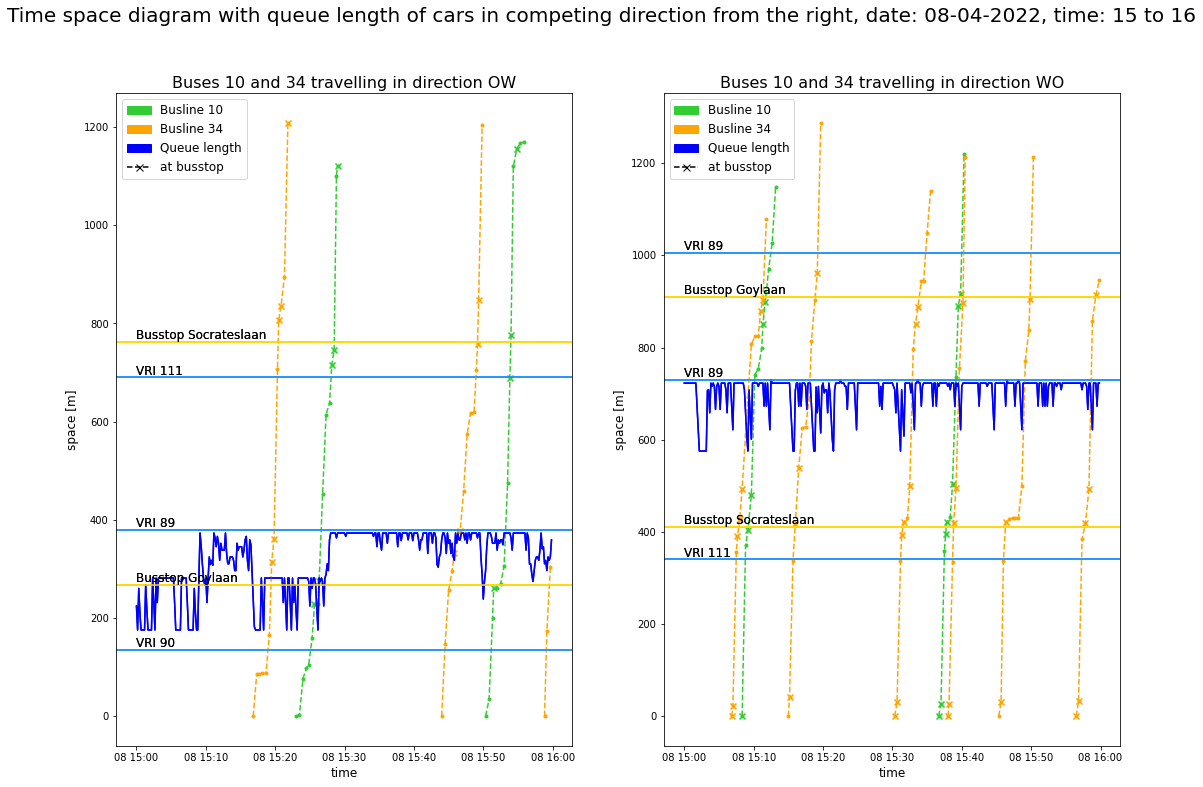

In [ ]:
#plot time-space diagram
fig = plt.figure(figsize=(18, 12))
plt.suptitle('Time space diagram with queue length of cars in competing direction from the right, date: {}, time: {} to {}'.format(date_start, h_start, h_end), fontsize =20)
fnum = 0
for direction in ['OW', 'WO']:
  #figure settings
  fnum = fnum+ 1
  ax=plt.subplot(1,2, fnum)
  ax.grid(visible = None, which = 'both')
  ax.set_xlabel('time', fontsize= 12)
  ax.set_ylabel('space [m]', fontsize= 12)
  ax.set_title('Buses 10 and 34 travelling in direction {}'.format(direction), fontsize=16)
  for line in ['u010', 'u034']: 
    ## bus trajcetory
    #only take time which is in the desired hour
    df_line = bus_traj_goy[line][bus_traj_goy[line].index.hour>= h_start]
    df_line = df_line[df_line.index.hour < h_end]
    df_line=df_line.dropna()
    for trip in df_line.journeynumber.unique():
      df_trip = df_line[df_line.journeynumber == trip]
      df_trip = df_trip[df_trip.direction == direction]
      t = df_trip.index
      dist = df_trip.dist_goy.values
      markerlabels = df_trip.messagetype
      ax.plot(t, dist, color = color_bus[line], marker = '.', linestyle= '--', label = 'trip {}'.format(trip))
      for idx, markerlabel in enumerate(markerlabels):
        if markerlabel == 'DEPARTURE' or markerlabel == 'ARRIVAL':
          ax.scatter(t[idx], dist[idx], linewidths = 5, marker = 'x', color = color_bus[line])
          #ax.annotate(markerlabel, (t[idx],dist[idx]), xytext=(3,3), textcoords='offset pixels')
        else :
          pass
      #if line == 'u010' and direction == 'WO':
        #display(df_trip)
        #pass

    ## queue length only at vri 89 available
    d_int= d_intersections[direction][1]

    #define approach of the intersection where queuelength should be plotted from
    if direction == 'OW':
      d= 'N'
    elif direction == 'WO':
      d= 'Z'
    vri = 89
    df_ql = queuelength[vri][d][queuelength[vri][d].index.hour >= h_start]
    df_ql = df_ql[df_ql.index.hour < h_end]
    t = df_ql.index
    ql = -df_ql.buffervulling_m + d_int # offset of d_intersection to plot ql at the height of the intersection
    ax.plot(t, ql, color = 'blue')
    
    #plot horizons of busstops and intersetions
    for i,value in enumerate(d_busstops[direction]):
      plt.axhline(y=value, color='gold', linestyle='-')
      ax.text(t[0], value, annotations_busstop[direction][i], horizontalalignment='left', verticalalignment= 'bottom', multialignment='center', fontsize = 12)
    for i,value in enumerate(d_intersections[direction]):
      plt.axhline(y=value, color='dodgerblue', linestyle='-')
      ax.text(t[0], value, annotations_intersections[direction][i], horizontalalignment='left', verticalalignment= 'bottom', multialignment='center', fontsize = 12)
  plt.legend(handles= [legend10, legend34, legendql, legendstp], loc = 'upper left', fontsize = 12)
#save figure
fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/Time Space diagram/timespace_competingdirection-right_{}_time_{}_to_{}.png'.format(line, h_start, h_end))


### Time-space of the whole busline

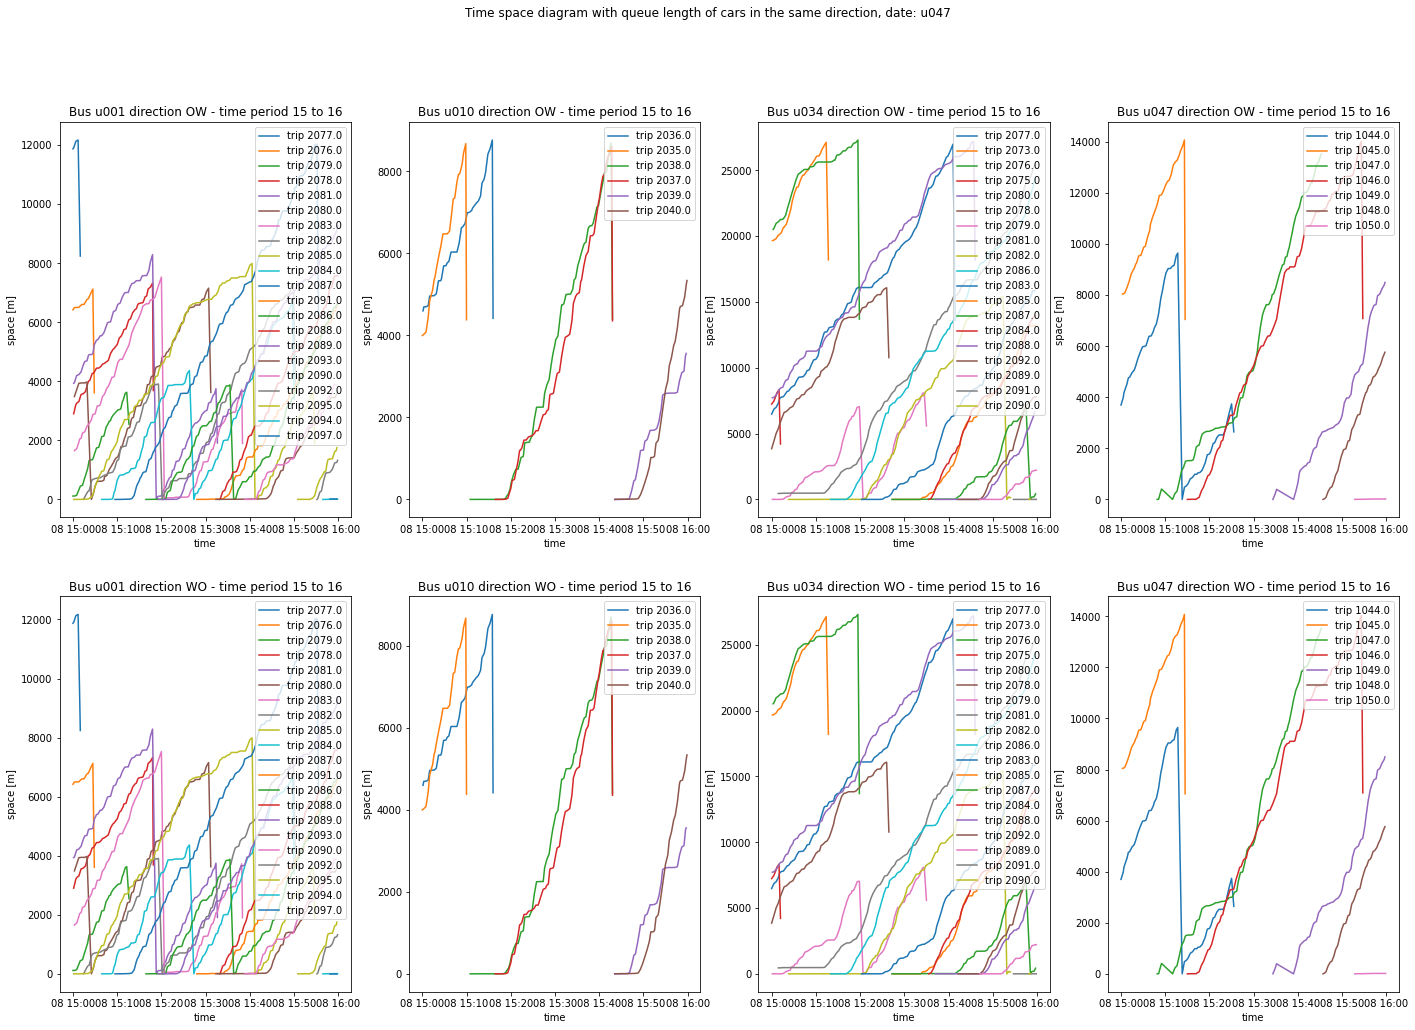

In [ ]:
#plot time-space diagram
fig = plt.figure(figsize=(len(buslines)*6, 2*8))
plt.suptitle('Time space diagram with queue length of cars in the same direction, date: {}'.format(line, date_start))
fnum = 0
for direction in ['OW', 'WO']:
  for line in buslines: 
    #figure settings
    fnum = fnum+ 1
    ax=plt.subplot(2,4, fnum)
    ax.grid(visible = None, which = 'both')
    ax.set_xlabel('time')
    ax.set_ylabel('space [m]')
    ax.set_title('Bus {} direction {} - time period {} to {}'.format(line, direction, h_start, h_end))
    

    #only take time which is in the desired hour
    df_line = bus_traj[line][bus_traj[line].index.hour>= h_start]
    df_line = df_line[df_line.index.hour < h_end]
    df_line=df_line.dropna()

    #df_ql = queuelength[vri][d][queuelength[vri][d].index.hour >= h_start]
    #df_ql = df_ql[df_ql.index.hour < h_end]


    for trip in df_line.journeynumber.unique():
      df_trip = df_line[df_line.journeynumber == trip]

      #display(df_trip)
      #only consider part on 't Goylaan  
    #identify busstop start and end, and select all points inbetween
    # ...
      t = df_trip.index
      dist = df_trip.cum_dist.values
      ax.plot(t, dist, label = 'trip {}'.format(trip))


      ax.legend(loc='upper right')
      #plt.show()
  #save figure
  #fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/Separated status/correlation_status_{}_vri{}_date_{}_{}_marg_delay_norm_{}.pdf'.format(status, vri, start, end, normalised))



### not used: *1b Method to select data which is actually on 't Goylaan*
- first calculate the euclidean distance between two consectuive data points, 
- then calculate the cumulative distance from the start per trip
- for each data point calculate the euclidean distance from the entry and exit point of the area of interest
- per bus line: find the minimum, and suppose that point as the starting/end point on 't Goylaan of that line's trajectory.
- per trip: define the direction of the bus (OW or WO)
- per trip: distance on 't Goylaan = cum_dist - cumulative dist of the entry point

Hypothesis: the bus has always the same trajectory and the calculation of the distance between the data points yield roughly the same values for different trips of the same busline, such that we can assume that the total length of all trips from the same line have the same length.

In [ ]:
bus_start = {'u001': {'OW': 50008050, 'WO': 59151801}, 'u010': {'OW': 50006542, 'WO': 51112300}, 'u034': {'OW': 50201100, 'WO': 50000141}, 'u047': {'OW': 50001400, 'WO': 50000122}}
bus_traj_goy = {l: pd.DataFrame() for l in buslines}
bus_dir = ['OW', 'WO']
for line in buslines: 
  df = bus_traj[line].reset_index(drop = False)
  for dir in bus_dir:
    df_dir = df[df.direction == dir]
    #overall minimum distance to entry point per line (not per trip) and per direction
    #in that way we can subtract from each trip the same cumulative distance to the entry point
    min1 = df_dir.dist_entry.min()
    print('minimum distance from ost and west point: bus {}: {}:{}'.format(line, dir, min1))
    index1 = int(df_dir.index[df_dir.dist_entry == min1][0])
    #per line : distance to subtract from cumulative distance to determine distance on 't goylaan
    cum_d_1 = df_dir.cum_dist[index1]
    print('distance to subtract in the bus trajectories: {}'.format(cum_d_1))
    trips = df_dir.journeynumber.unique()
    for trip in trips: 
      df_trip = df_dir[df_dir['journeynumber'] == trip].reset_index(drop = True)
      if not df_trip.empty:
        #segment of the trip which is on 't goylaan
        min1 = df_trip.dist_entry.min()
        min2 = df_trip.dist_exit.min()
        index1 = int(df_trip.index[df_trip.dist_entry == min1][0])
        index2 = int(df_trip.index[df_trip.dist_exit== min2][0])
        df_trip_goylaan = df_trip[index1 :index2+1].reset_index(drop = True) 
        #distance on t goylaan, can add +minW but not sure if + or -
        df_trip_goylaan['dist_goy'] = [x- cum_d_1 for x in df_trip_goylaan.cum_dist] 
        #add data frames together
        bus_traj_goy[line] = pd.concat([bus_traj_goy[line], df_trip_goylaan]).reset_index(drop= True) 
  bus_traj_goy[line].set_index('time', inplace = True)






minimum distance from ost and west point: bus u001: OW:2.0
distance to subtract in the bus trajectories: 901.0
minimum distance from ost and west point: bus u001: WO:345.0
distance to subtract in the bus trajectories: 2510.0
minimum distance from ost and west point: bus u010: OW:9.0
distance to subtract in the bus trajectories: 1434.0
minimum distance from ost and west point: bus u010: WO:13.0
distance to subtract in the bus trajectories: 6221.0
minimum distance from ost and west point: bus u034: OW:7.0
distance to subtract in the bus trajectories: 13921.0
minimum distance from ost and west point: bus u034: WO:12.0
distance to subtract in the bus trajectories: 1265.0
minimum distance from ost and west point: bus u047: OW:381.0
distance to subtract in the bus trajectories: 54.0
minimum distance from ost and west point: bus u047: WO:1.0
distance to subtract in the bus trajectories: 2798.0


### not used: *2nd Method to select data on 't goylaan*
- use busstop coordinates (from NDOV data)
- use busstop as fixpoint 
- choose starting point 2 timesteps ahead, 
- and end point around 5 timesteps after.
- 

In [ ]:
#bus id of start busstops
entry_busstops = {'u001': {'OW': 50002380,'WO': 50001282}, 'u010': {'OW': 50006470,'WO': 50001241}, 'u034': {'OW': 50100420,'WO': 50001241}, 'u047': {'OW': 51180036,'WO':50001390 }}
#busstop coordinates of start busstop
stp_coord_start = {'OW': [136768.0,	453120.0], 'WO': [135906.0,	453190.0]}
for line in buslines: 
  for dir in bus_dir: 
    df_dir = bus_traj[line][bus_traj[line].direction == dir].reset_index(drop=False)
    for trip in bus_traj[line].journeynumber.unique():
      df_trip = df_dir[df_dir.journeynumber == trip].reset_index(drop=True)
      stp= df_trip[(df_trip.userstopcode == entry_busstops[line][dir])]
      idx_stp= stp.index
      #calculate distance between stp and entry [m] = d1
      #define entry point as point where cum_dist_0 = cum_dist_stop -d1
      #exit point idem
       
      #df_trip_goylaan = df_trip[idx_stp-2: idx_stp+5].reset_index(drop=True)

#line = 'u010'
#bus_traj[line]